In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm
import re
import sys
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

# My functions
sys.path.insert(0,'../')
import utils

# Useful variables
e = np.exp(1)
idx = pd.IndexSlice
_ = np.newaxis

# Load style file
plt.style.use('../fig.style')

In [2]:
# Load MPSA data
elp1_df = pd.read_csv('../data/mpsa_data_elp1.csv', index_col=0)
elp1_df.head()

,elp1_dmso,elp1_rg,elp1_nvs
ss,,,
AAAA/GCAAAA,0.0,0.025349,0.108121
AAAA/GCAAAG,0.0,0.000000,0.000000
AAAA/GCAAGA,0.0,0.000000,0.000000
AAAA/GCAAGG,0.0,0.004373,0.000000
AAAA/GCAAUC,0.0,0.000000,0.000000


In [3]:
valid_ss = elp1_df.index.values
len(valid_ss)

30807

analyzing lib1, i.e. ../data/mpsa/cipher_files/cipher.ikbkap_9nt_ssbc_lib1.txt...
analyzing lib2, i.e. ../data/mpsa/cipher_files/cipher.ikbkap_9nt_ssbc_lib2.txt...


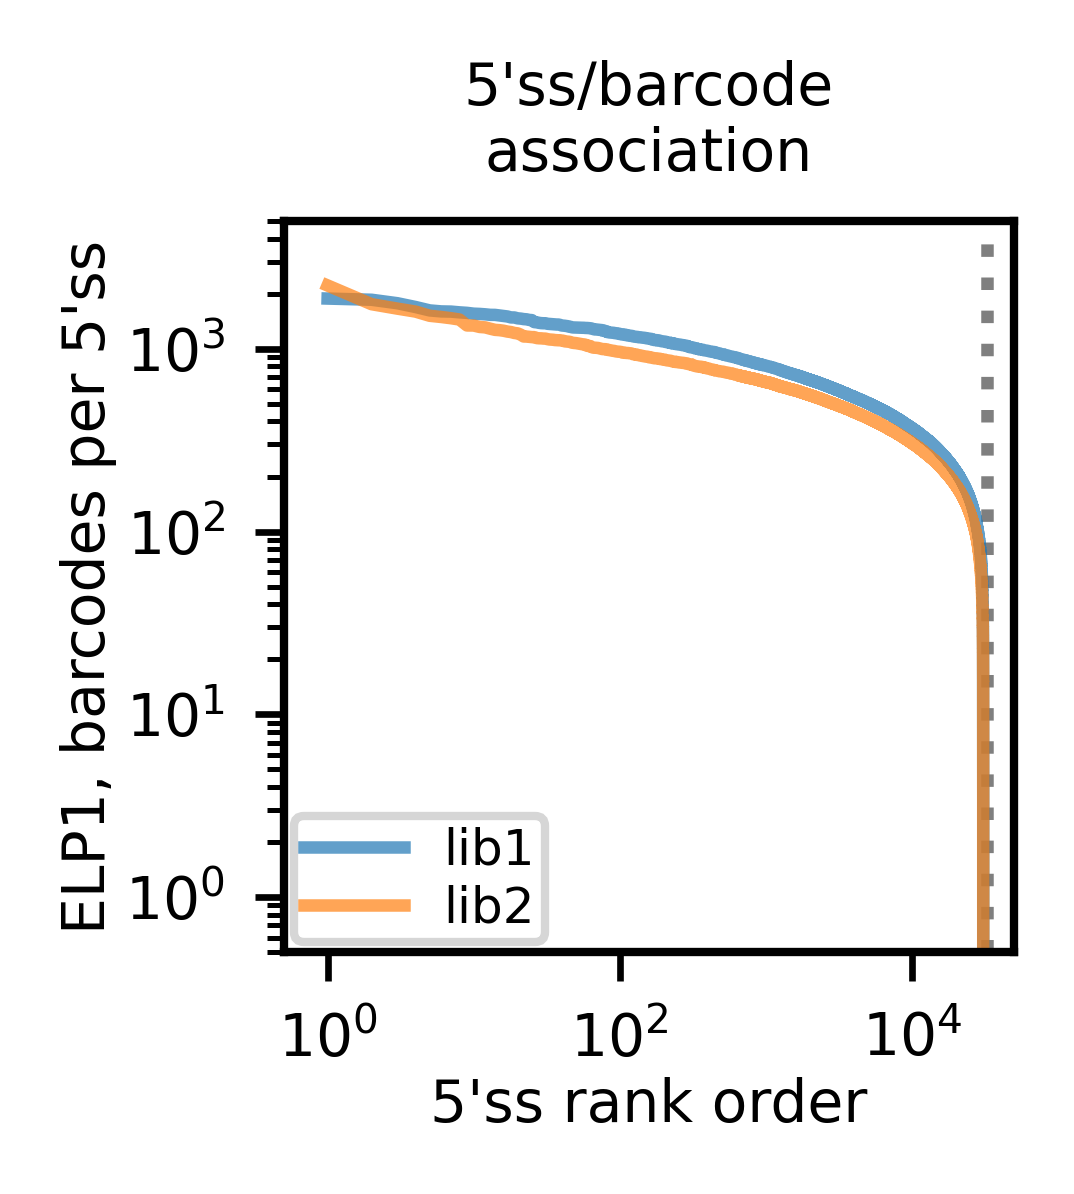

In [4]:
# Specify mapping from lib number to ssbc lib name
lib_num_to_ssbc_lib_name_dict = {
    1:'ikbkap_9nt_ssbc_lib1',
    2:'ikbkap_9nt_ssbc_lib2'}

# Specify drawing funciton
import pdb
def draw_num_bc(ax):
    
    # Summarize number of barcodes for each 5'ss in each lib
    num_bc_df = pd.DataFrame(index=valid_ss)
    for lib_num in [1,2]:
        file_name = f'../data/mpsa/cipher_files/cipher.{lib_num_to_ssbc_lib_name_dict[lib_num]}.txt'
        col = f'lib{lib_num}'
        print(f'analyzing {col}, i.e. {file_name}...')
        tmp_df = pd.read_csv(file_name, sep='\t', index_col=0).fillna(0)
        tmp_df['ss'] = ['A'+s.replace('T','U') for s in tmp_df['ss']]
        tmp_df['ss'] = [s[:4]+'/'+s[4:] for s in tmp_df['ss']]
        tmp_df = tmp_df[tmp_df['ss'].isin(valid_ss)]
        num_bc_df[col] = tmp_df[['ss','ct']].groupby('ss').sum()
    
    num_bc_df = num_bc_df.fillna(0)
    for lib_num in [1,2]:
        col = f'lib{lib_num}'
        vals = num_bc_df[col].values
        vals = np.sort(vals)[::-1]
        x = np.arange(1,len(vals)+1)
        num_5ss = len(vals)
        ax.plot(x, vals, label=f'lib{lib_num}', alpha=.7)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([.5, 50_000])
    ax.set_xticks([1, 100, 10_000])
    ax.set_xlabel(f'5\'ss rank order')
    ax.set_ylabel(f'ELP1, barcodes per 5\'ss')
    ax.set_title('5\'ss/barcode\nassociation')
    ax.axvline(32_768, linestyle=':', color='k', alpha=.5, zorder=-100)
    ax.set_ylim([5E-1, 5E3])
    ax.legend(loc='lower left', fontsize=6)
    
# Make figure S1
fig, ax = plt.subplots(1,1,figsize=[1.8, 2.0], sharey=False)
draw_num_bc(ax=ax)
plt.tight_layout()
fig.savefig('figS2E.pdf', facecolor=None)

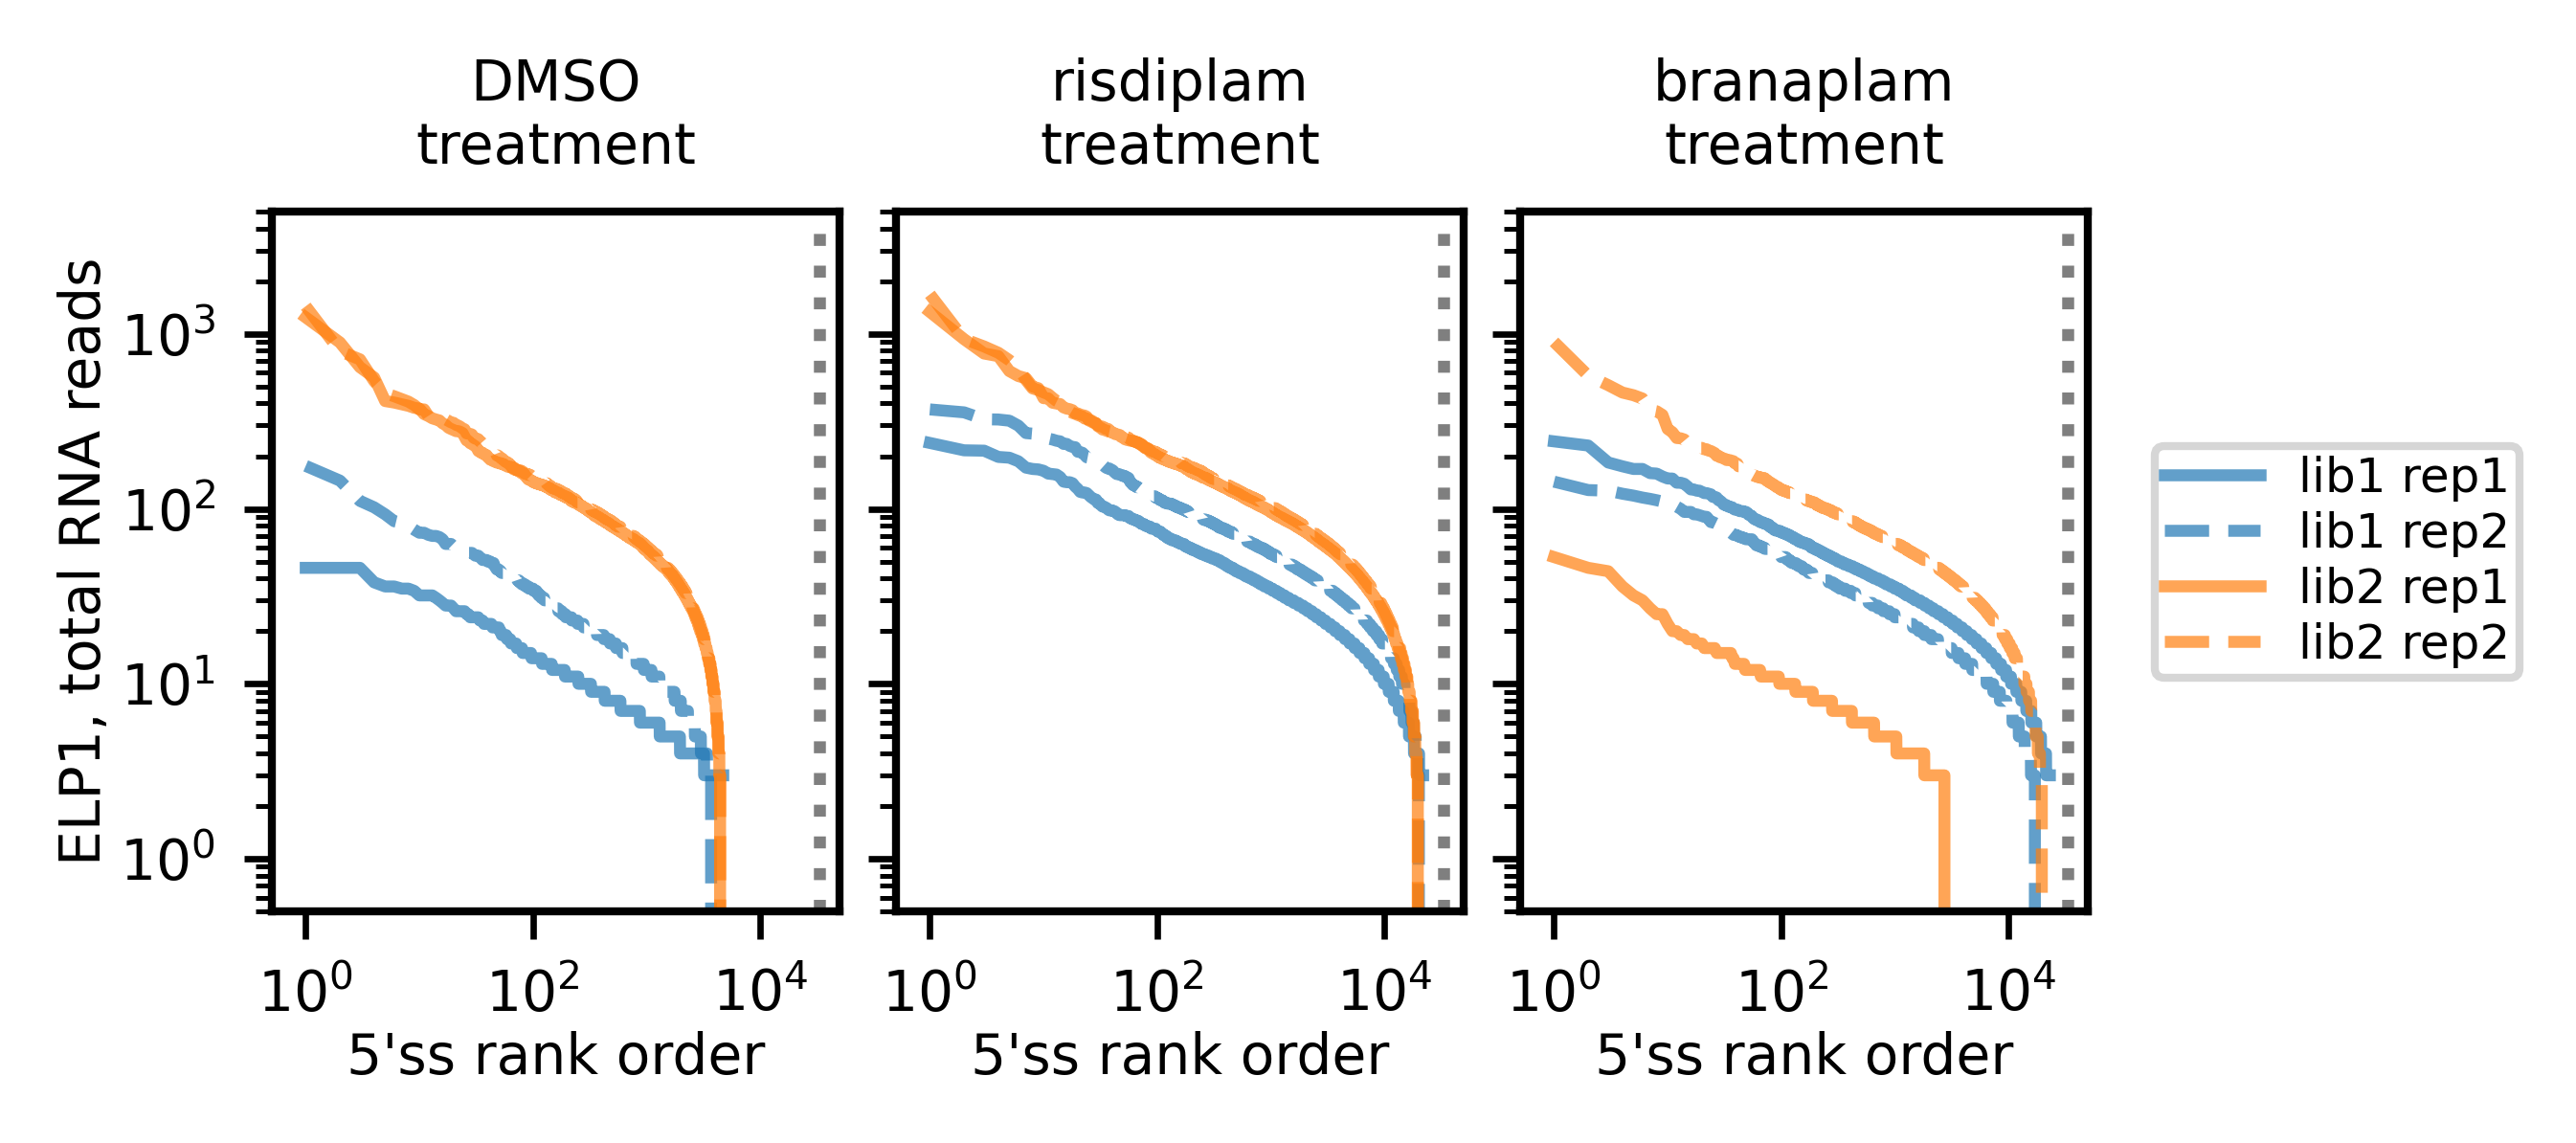

In [6]:
treatment_to_file_name_dict = {
    'DMSO':'total_elp1_dmso.csv',
    'risdiplam':'total_elp1_rg.csv',
    'branaplam':'total_elp1_nvs.csv',
}

lib_num_to_color = {
    1:'C0',
    2:'C1',
}

rep_num_to_linestyle = {
    1:'-',
    2:'--'
}

# Specify drawing funciton
def draw_num_reads(treatment, ax, legend=None, show_ylabel=False):
    file_name = f'../data/mpsa/{treatment_to_file_name_dict[treatment]}'
    tmp_df = pd.read_csv(file_name, sep=',', index_col=0).fillna(0)
    for lib_num in [1,2]:
        for rep_num in [1,2]:
            col = f'ikbkap_select_lib{lib_num}_rep{rep_num}'
            label = f'lib{lib_num} rep{rep_num}'
            vals = tmp_df[col].values
            vals = np.sort(vals)[::-1]
            x = np.arange(1,len(vals)+1)
            ax.plot(x, vals, alpha=.7, label=label, 
                    color=lib_num_to_color[lib_num], 
                    linestyle=rep_num_to_linestyle[rep_num])
            
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([.5, 50_000])
    ax.set_xticks([1, 100, 10_000])
    ax.set_xlabel(f'5\'ss rank order')
    if show_ylabel:
        ax.set_ylabel(f'ELP1, total RNA reads')
    else:
        ax.set_yticklabels('')
    ax.set_title(f'{treatment}\ntreatment')
    ax.axvline(32_768, linestyle=':', color='k', alpha=.5, zorder=-100)
    ax.set_ylim([5E-1, 5E3])
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=6)

# Make figure S1
fig, axs = plt.subplots(1,3,figsize=[4.5, 2.0], sharey=False)
treatments = ['DMSO', 'risdiplam', 'branaplam']

draw_num_reads(treatment='DMSO', ax=axs[0], show_ylabel=True)

draw_num_reads(treatment='risdiplam', ax=axs[1])

draw_num_reads(treatment='branaplam', ax=axs[2], legend=True)
    
fig.tight_layout(w_pad=.5)
fig.savefig('figS2F.pdf', facecolor=None)